<a href="https://colab.research.google.com/github/albanda/CE888/blob/master/lab3/facebook_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder


* We have loaded the necessary libraries above
* Now let's load the data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab3/dataset_Facebook.csv", delimiter = ";")

features = ["Category",
            "Page total likes",
            "Type",
            "Post Month",
            "Post Hour",
            "Post Weekday",
            "Paid"]


df[features].head()

,Category,Page total likes,Type,Post Month,Post Hour,Post Weekday,Paid
0,2,139441,Photo,12,3,4,0.0
1,2,139441,Status,12,10,3,0.0
2,3,139441,Photo,12,3,3,0.0
3,2,139441,Photo,12,10,2,1.0
4,2,139441,Photo,12,3,2,0.0


In [ ]:
outcomes=  ["Lifetime Post Total Reach",
            "Lifetime Post Total Impressions",
            "Lifetime Engaged Users",
            "Lifetime Post Consumers",
            "Lifetime Post Consumptions",
            "Lifetime Post Impressions by people who have liked your Page",
            "Lifetime Post reach by people who like your Page",
            "Lifetime People who have liked your Page and engaged with your post",
            "comment",
            "like",
            "share",
            "Total Interactions"]

df[outcomes].head()

print(df[outcomes[-3:]].head().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    like &  share &  Total Interactions \\
\midrule
0 &    79.0 &   17.0 &                 100 \\
1 &   130.0 &   29.0 &                 164 \\
2 &    66.0 &   14.0 &                  80 \\
3 &  1572.0 &  147.0 &                1777 \\
4 &   325.0 &   49.0 &                 393 \\
\bottomrule
\end{tabular}



In [ ]:
# convert a string variable to a categorical one
df[["Type"]] = df[["Type"]].apply(LabelEncoder().fit_transform)

df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,1,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,2,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,1,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,1,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,1,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


Now let's prepare the data by cleaning it up and choosing the relevant column we would like to predict

In [ ]:
df = df.dropna()

outcomes_of_interest = ["Lifetime Post Consumers", "like"]
n_bins = 20

X_df = df[features].copy()
y_df = df[outcomes_of_interest].copy()

#print X_df.head().to_latex()

#print y_df.values
bins =  pd.qcut(y_df[outcomes_of_interest[0]].values,n_bins)

y_df = df[outcomes_of_interest].copy()
y_df[outcomes_of_interest[0]] = bins

y_df[outcomes_of_interest] = y_df[outcomes_of_interest].apply(LabelEncoder().fit_transform)

print(y_df.head())

   Lifetime Post Consumers  like
0                        0    73
1                       17   113
2                        0    61
3                       13   252
4                        6   205


In [ ]:
X = X_df.values
y = y_df.values.T[0]

y_df['id'] = range(1, len(df) + 1)

y_df.head()

,Lifetime Post Consumers,like,id
0,0,73,1
1,17,113,2
2,0,61,3
3,13,252,4
4,6,205,5


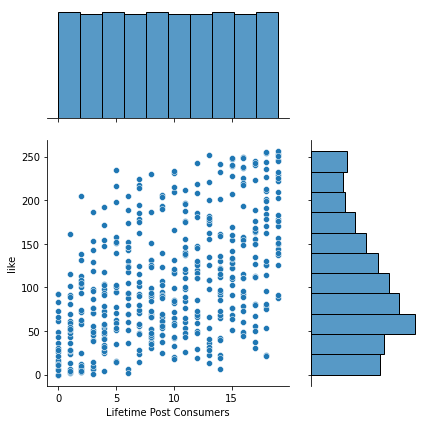

In [ ]:
sns_plot = sns.jointplot(x="Lifetime Post Consumers", y="like", data=y_df, ratio=2)

#sns_plot.savefig("joint_plot.pdf", bbox_inches='tight')

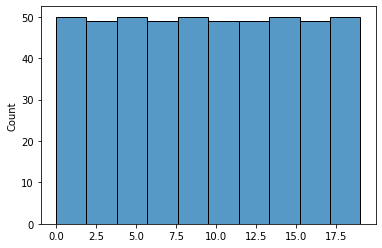

In [ ]:
sns_plot = sns.histplot(y, kde=False)

#sns_plot.savefig("histogram_lpc.pdf", bbox_inches='tight')

In [ ]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X, y)
print("Dummy ACC: %.2f" % acc(y, dummy_clf.predict(X)))

Dummy ACC: 0.05


In [ ]:
clf = ExtraTreesClassifier(n_estimators=1000, max_depth=4)
scores = cross_val_score(clf, X, y, cv=10, scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.15 +/- 0.04


Now let's train the classifier on the whole dataset

In [ ]:
clf = ExtraTreesClassifier(n_estimators=20000, max_depth=4)
clf.fit(X, y)
print("ExtraTrees ACC = %.2f" % acc(y, clf.predict(X)))

ExtraTrees ACC = 0.41


[3 1 2 0 5 4 6]
Feature ranking:
1. Post Month (0.266417)
2. Page total likes (0.234008)
3. Type (0.209396)
4. Category (0.083565)
5. Post Weekday (0.072930)
6. Post Hour (0.070329)
7. Paid (0.063356)


(0.0, 0.4419226296948641)

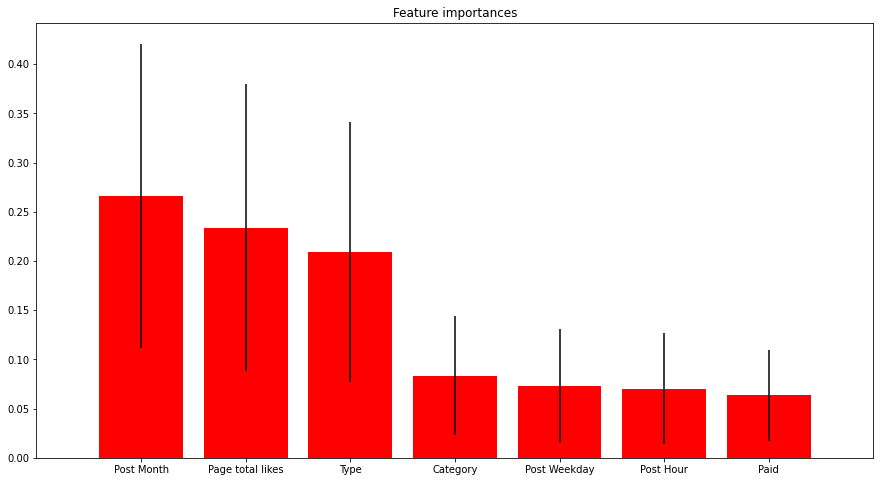

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices])
plt.xlim([-1, X.shape[1]])
plt.ylim([0, None])

fig.set_size_inches(15, 8)

# plt.savefig("importances.pdf", bbox_inches='tight')

In [ ]:
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    conf_mat: confusion matrix
    classes: names of classes to be annotated
    normalize: [True/False] whether to normalise by column
    """
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Normalized confusion matrix


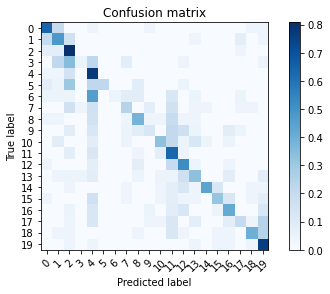

In [ ]:
# Compute confusion matrix
y_pred = clf.predict(X)
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y))), normalize=True,
                      title='Confusion matrix')

#plt.savefig("confusion.pdf", bbox_inches='tight')